# 前処理

In [2]:
import json
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/runble1/.pyenv/versions/3.6.1/envs/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


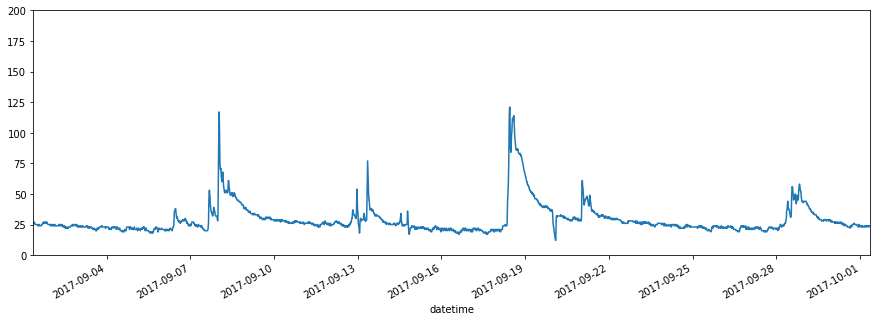

In [3]:
# メートルからセンチメートルへ変換（×100）
df_level_all = pd.read_json("waterLevelSeptember.json")
df_level_all = df_level_all.set_index('datetime')
df_level_all.index = df_level_all.index.tz_localize('UTC')
df_level_all.index = df_level_all.index.tz_convert('Asia/Tokyo')
df_level_all.index = df_level_all.index.tz_localize(None)
df_level = df_level_all.loc[
   (df_level_all['level'] != '-') 
    & (df_level_all['level'] != '&&nbsp;1.10')
    & (df_level_all['level'] != '&&nbsp;1.41')]
df_level["level"] = df_level["level"].astype(np.float64) * 100
df_level["level"].plot(figsize=(15,5), ylim=(0,200))

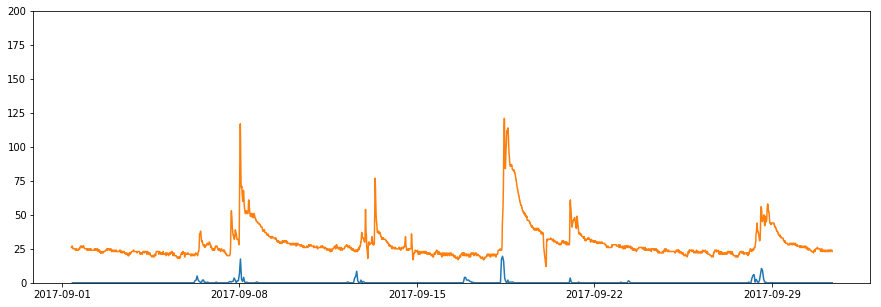

In [4]:
# ミリ
filename = "rainfall09.csv"
df = pd.read_csv(filename,encoding="SHIFT-JIS",skiprows=4)
df_rain = df.iloc[:,0:2]
df_rain.columns = ["timestamp", "rain"]
df_rain["timestamp"] = df_rain.timestamp.map(lambda _: pd.to_datetime(_))
df_rain = df_rain.set_index('timestamp')
df_rain.index = df_rain.index.tz_localize('UTC')
df_rain.index = df_rain.index.tz_convert('Asia/Tokyo')
df_rain.index = df_rain.index.tz_localize(None)
plt.figure(figsize=(15,5))
plt.ylim(0,200)
plt.plot(df_rain.rain)
plt.plot(df_level.level )

In [5]:
# 降水量の期間(1年)を水位の期間(1ヶ月)に合わせる
df_rain = df_rain[df_rain.index < df_level.index.max()]
df_rain = df_rain[df_rain.index > df_level.index.min()]
'''
1時間前の水位の変化と降水量から、1時間後の最大水位を予測する
60分に7点データ(1/1 00:00:00 ~ 1/1 01:00:00)ある
欠損(NaN)を考えると6点データが限界？
降水量のtimestampは１時間前のものである
'''
ixs = df_rain.index

df = []
y = []

for i in range(len(ixs)-3):

    dt1 = ixs[i + 1]
    dt2 = ixs[i + 2]
    dt3 = ixs[i + 3]

    d1 = df_level[dt1:dt2].level.tolist()
    d2 = df_level[dt2:dt3].level.tolist()

    # 7以下でNaNが含まれず、かつ、なるべく多くのデータをとりたい
    # とりあえず5
    if len(d1) > 5 and len(d2) > 5:
        y.append(max(d2))
        d1.sort()
        d1.reverse()
        d1 = d1[:5]
        d1.append(df_rain.ix[i].rain)
        df.append(d1)
        
df = pd.DataFrame(df)
df['y'] = y

df.shape

/Users/runble1/.pyenv/versions/3.6.1/envs/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


(349, 7)

# 機械学習

In [9]:
X_cols = df.columns[:-1]
# データを入力と出力に分割
X = df[X_cols].as_matrix().astype("float")
y = df.y.as_matrix().astype("int").flatten()
# 7割を学習データ、3割を検証データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# スケール変換器
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# スケール変換器の適合
scaler.fit(X_train)

# スケール変換
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)

model.fit(X_train_scaled, y_train)
# testに対してｓ
result = model.predict(X_test)

print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled,y_test))

0.949203245548
0.932984973532


# 予測・可視化
スクレイピングで予測雨量をとってくる
わたす

In [19]:
#  新たなデータセットを作成
pp = pd.DataFrame(
    {'act': np.array(y_test), "pred": np.array(result), "rain": X_test[:,-1]})
#pp = pd.DataFrame({"pred": np.array(result), "rain": X_test[:,-1]})

pp.head()

,act,pred,rain
0,22,76.9,1.0
1,25,79.3,0.0
2,25,79.3,0.0
3,23,79.3,0.0
4,21,79.3,0.0


In [18]:
pp.rain = pp.rain * 5
pp.head()

,act,pred,rain
0,22,76.9,25.0
1,25,79.3,0.0
2,25,79.3,0.0
3,23,79.3,0.0
4,21,79.3,0.0


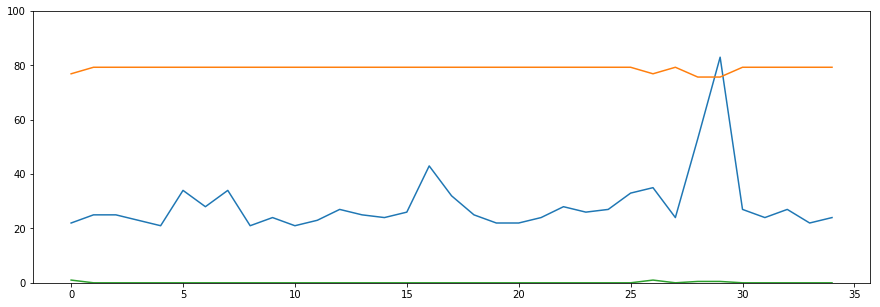

In [20]:
# 
plt.figure(figsize=(15,5))
plt.ylim(0,100)
#  
plt.legend = pp.columns
#  
plt.plot(pp)